In [1]:
## system imports
import sys, os
import time
import copy

## loading imports
import json

## math imports
import numpy as np

## COCO imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask
from pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import skimage.io as io

In [2]:
'''
Set paths to data and load data
'''
## set paths of ground truth and detections
BASE_DIR = '/home/mronchi/Research/keypoint-2d-eval'
COCO_GT  = BASE_DIR + '/data/test_dev/person_keypoints_test-dev2015.json'
SAVE_DIR = BASE_DIR + '/outputs/scoring_errors'

DTS  = BASE_DIR + '/data/team_res/maskrnn9.json'

print "\n==============================================="
print "COCO_GT:  [%s]"%COCO_GT
print "DTS:      [%s]"%DTS
print "SAVE_DIR: [%s]"%SAVE_DIR
print "===============================================\n"

## load coco ground-truth
coco_gt = COCO( COCO_GT )
print("{:15}[{}] instances in [{}] images.".format('Ground-truth:',
                                                   len(coco_gt.getAnnIds()),
                                                   len(coco_gt.getImgIds())))

## create imgs_info dictionary
with open(COCO_GT,'rb') as fp:
    data = json.load(fp)
imgs_info = {i['id']:{'id':i['id'] , 
                      'width':i['width'], 
                      'height':i['height']} 
                       for i in data['images']}
assert(len(coco_gt.getImgIds())==len(imgs_info))


COCO_GT:  [/home/mronchi/Research/keypoint-2d-eval/data/test_dev/person_keypoints_test-dev2015.json]
DTS:      [/home/mronchi/Research/keypoint-2d-eval/data/team_res/maskrnn9.json]
SAVE_DIR: [/home/mronchi/Research/keypoint-2d-eval/outputs/scoring_errors]

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
Ground-truth:  [43862] instances in [20288] images.


In [3]:
################################################################################
## load team detections
with open(DTS,'rb') as fp: team_dts = json.load(fp)

dt_img_ids = set([d['image_id'] for d in team_dts if d['image_id'] in imgs_info])
dts     = [d for d in team_dts if d['image_id'] in dt_img_ids]
print("{:15}[{}] instances in [{}] images.".format('Detections:',
                                                   len(dts),
                                                   len(dt_img_ids)))
## create detection object
coco_dt   = coco_gt.loadRes(dts)
## deep cody ground truth object
#coco_gt = copy.deepcopy(coco_gt)

## create analyze object
coco_analyze = COCOanalyze(coco_gt,coco_dt,'keypoints')

Detections:    [242657] instances in [18709] images.
Loading and preparing results...
DONE (t=4.30s)
creating index...
index created!


In [ ]:
# analyze at loosest threshold because it contains all of the errors
coco_analyze.params.oksThrs       = [.5]
coco_analyze.params.areaRng       = [[32 ** 2, 1e5 ** 2]]
coco_analyze.params.areaRngLbl    = ['all']

#coco_analyze.evaluate(makeplots=True)
coco_analyze.analyze( check_kpts=False, check_scores=True, check_bkgd=True)
coco_analyze.summarize(makeplots=True)

In [ ]:
# find which images have people annotations in them but are not detected
imgs_wo_dts = [image_id for image_id in imgs_info if image_id not in dt_img_ids]
imgs_w_dts  = list(set([x['image_id'] for x in coco_analyze.corrected_dts]))
imgs_w_gts  = [image_id for image_id in imgs_info if coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=image_id))]
imgs_wo_gts = [image_id for image_id in imgs_info if not coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=image_id))]
correct_wo_dts = set(imgs_wo_dts) & set(imgs_wo_gts)
correct_w_dts  = set(imgs_w_dts) & set(imgs_w_gts)

print "Number images wo dts: ",len(imgs_wo_dts)
print "Number images w dts:  ",len(imgs_w_dts)
print "Number images wo gts: ",len(imgs_wo_gts)
print "Number images w gts & w dts  : ",len(correct_w_dts)
print "Number images wo gts & wo dts: ",len(correct_wo_dts)

In [ ]:
def merge_and_count(a, b):
    assert a == sorted(a) and b == sorted(b)
    c = []
    count = 0
    i, j = 0, 0
    while i < len(a) and j < len(b):
        c.append(min(b[j], a[i]))
        if b[j] < a[i]:
            count += len(a) - i # number of elements remaining in `a`
            j+=1
        else:
            i+=1
    # now we reached the end of one the lists
    c += a[i:] + b[j:] # append the remainder of the list to C
    return count, c

def sort_and_count(L):
    if len(L) == 1: return 0, L
    n = len(L) // 2 
    a, b = L[:n], L[n:]
    ra, a = sort_and_count(a)
    rb, b = sort_and_count(b)
    r, L = merge_and_count(a, b)
    return ra+rb+r, L

def number_of_swaps(permutation):
    """Find number of swaps required to convert the permutation into
    identity one.

    """
    # decompose the permutation into disjoint cycles
    nswaps = 0
    seen = set()
    for i in xrange(len(permutation)):
        if i not in seen:           
            j = i # begin new cycle that starts with `i`
            while permutation[j] != i: # (i σ(i) σ(σ(i)) ...)
                j = permutation[j]
                seen.add(j)
                nswaps += 1
    return nswaps

def get_permutation(L1, L2):
    """Find permutation that converts L1 into L2.

    See http://en.wikipedia.org/wiki/Cycle_representation#Notation
    """
    if sorted(L1) != sorted(L2):
        raise ValueError("L2 must be permutation of L1 (%s, %s)" % (L1,L2))

    permutation = map(dict((v, i) for i, v in enumerate(L1)).get, L2)
    assert [L1[p] for p in permutation] == L2
    return permutation

In [ ]:
suboptimal_dts_ranking = []
optimal_dts_ranking    = []
skip_gt_ignores     = False

adj_swaps     = []
non_adj_swaps = []

# cmu_opt_score_fp = []
# cmu_ori_score_fp = []

# cmu_opt_score_ignores = []
# cmu_ori_score_ignores = []

# cmu_opt_score_oks = []
# cmu_ori_score_oks = []

# for all the images which have a detection
for image_id in imgs_w_dts:
    if skip_gt_ignores:
        image_gts = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=image_id))
        are_there_ignore_gts = [x['_ignore'] for x in image_gts]
        # skip this image if there are ignore ground truths in it
        if np.any(np.array(are_there_ignore_gts)==True):
            continue
    
    # get the corrected detections for that image
    image_dts = [d for d in coco_analyze.corrected_dts if d['image_id']==image_id]
    
    # check if optimal scoring and original scoring have the same ordering
    opt_score = [d['id'] for d in sorted(image_dts, key=lambda k: -k['opt_score'])]
    ori_score = [d['id'] for d in sorted(image_dts, key=lambda k: -k['score'])]
       
    idx_permutation   = get_permutation(opt_score, ori_score)
    num_adj_swaps     = sort_and_count(idx_permutation)[0]
    num_non_adj_swaps = number_of_swaps(idx_permutation)
    adj_swaps.append(num_adj_swaps)
    non_adj_swaps.append(num_non_adj_swaps)

    # this image has optimal ranking of detections by score
    if num_adj_swaps == 0:
        optimal_dts_ranking.append(image_id)
        continue
    
    # this image has suboptimal ranking of detections by score
    suboptimal_dts_ranking.append(image_id)

print len(optimal_dts_ranking)
print len(suboptimal_dts_ranking)

In [ ]:
# look at all the matches with original score and with optimal score

ori_gts_match = []
opt_gts_match = []
ori_gts_fn    = []
opt_gts_fn    = []

ori_dts_match = []
opt_dts_match = []
ori_dts_fp    = []
opt_dts_fp    = []

# opt_score_fp = 0
# ori_score_fp = 0

# opt_score_ignores = 0
# ori_score_ignores = 0

# opt_score_oks = 0.
# ori_score_oks = 0.

image_ids_no_gts_subopt_ranking = []

for image_id in suboptimal_dts_ranking:
    image_dts = [d for d in coco_analyze.corrected_dts if d['image_id']==image_id]
    image_gts = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=image_id))
    
    if len(image_gts) == 0: image_ids_no_gts_subopt_ranking.append(image_id)
    
    #print len(image_gts)
    for g in image_gts:
        #print "-------------"
        #print g
        if g['id'] in coco_analyze.score_matches['gts']:
            #print coco_analyze.score_matches['gts'][g['id']]
            if len(coco_analyze.score_matches['gts'][g['id']]) != 1:
                #print image_dts, len(image_dts)
                #print 
                #print image_gts, len(image_gts)
                #print
                #print g
                #print 
                #print coco_analyze.score_matches['gts'][g['id']]
                assert(g['ignore'])
                ori_gts_match.extend(coco_analyze.score_matches['gts'][g['id']])
            else:
                ori_gts_match.append(coco_analyze.score_matches['gts'][g['id']][0])
        else:
            #print "%d original false neg"%g['id']
            ori_gts_fn.append(g['id'])

        if g['id'] in coco_analyze.opt_score_matches['gts']:
            #print coco_analyze.opt_score_matches['gts'][g['id']]
            if len(coco_analyze.opt_score_matches['gts'][g['id']])!=1:
                assert(g['ignore'])
                opt_gts_match.extend(coco_analyze.opt_score_matches['gts'][g['id']])
            else:
                opt_gts_match.append(coco_analyze.opt_score_matches['gts'][g['id']][0])
        else:
            #print "%d new false neg"%g['id']
            opt_gts_fn.append(g['id'])
        
    #print
    
    #print len(image_dts)
    for d in image_dts:
        #print "-------------"
        #print d
        if d['id'] in coco_analyze.score_matches['dts']:
            #print coco_analyze.score_matches['dts'][d['id']]
            assert(len(coco_analyze.score_matches['dts'][d['id']])==1)
            ori_dts_match.append(coco_analyze.score_matches['dts'][d['id']][0])
        else:
            #print "%d original false pos"%d['id']
            ori_dts_fp.append(d['id'])
        if d['id'] in coco_analyze.opt_score_matches['dts']:
            #print coco_analyze.opt_score_matches['dts'][d['id']]
            assert(len(coco_analyze.opt_score_matches['dts'][d['id']])==1)
            opt_dts_match.append(coco_analyze.opt_score_matches['dts'][d['id']][0])
        else:
            #print "%d new false pos"%d['id']
            opt_dts_fp.append(d['id'])

print len(image_ids_no_gts_subopt_ranking)
#     print 
    
#     print ori_gts_match
#     print opt_gts_match
#     print ori_gts_fn
#     print opt_gts_fn

#     print
    
#     print ori_dts_match
#     print opt_dts_match
#     print ori_dts_fp
#     print opt_dts_fp
    
#     assert(False)

#     for d in image_dts:
        
#         ################################
#         # statistics with previous score
#         if d['id'] not in cmu_coco_analyze.score_matches['dts']:
#             # detection has no match
#             ori_score_fp += 1
#         else:
#             # detection has a match
#             if cmu_coco_analyze.score_matches['dts'][d['id']][0]['ignore'] == 1:
#                 # detection should be ignored
#                 ori_score_ignores += 1
#             else:
#                 ori_score_oks += cmu_coco_analyze.score_matches['dts'][d['id']][0]['oks']

#         ################################
#         # statistics with new score
#         if d['id'] not in cmu_coco_analyze.opt_score_matches['dts']:
#             # detection has no match
#             opt_score_fp += 1
#         else:
#             # detection has a match
#             if cmu_coco_analyze.opt_score_matches['dts'][d['id']][0]['ignore'] == 1:
#                 # detection should be ignored
#                 opt_score_ignores += 1
#             else:
#                 opt_score_oks += cmu_coco_analyze.opt_score_matches['dts'][d['id']][0]['oks']

In [ ]:
print len(ori_gts_match), len(opt_gts_match), len(ori_gts_match)-len(opt_gts_match)
print len(ori_gts_fn), len(opt_gts_fn), len(ori_gts_fn)-len(opt_gts_fn)
print 
print len(ori_dts_match), len(opt_dts_match), len(ori_dts_match)-len(opt_dts_match) 
print len(ori_dts_fp), len(opt_dts_fp), len(ori_dts_fp)-len(opt_dts_fp)

opt_gts_match_s = copy.deepcopy(sorted(opt_gts_match, key=lambda k: k['dtId']))
opt_dts_match_s = copy.deepcopy(sorted(opt_dts_match, key=lambda k: k['dtId']))
ori_gts_match_s = copy.deepcopy(sorted(ori_gts_match, key=lambda k: k['dtId']))
ori_dts_match_s = copy.deepcopy(sorted(ori_dts_match, key=lambda k: k['dtId']))

In [ ]:
# for i,j in zip(ori_gts_match_s,ori_dts_match_s):
#     j.pop('score')
#     if i != j:
#         print i
#         print j
#         assert(False)

# for i,j in zip(opt_gts_match_s,opt_dts_match_s):
#     j.pop('score')
#     if i != j:
#         print i
#         print j
#         assert(False)

ori_matches = copy.deepcopy(ori_dts_match_s)
opt_matches = copy.deepcopy(opt_dts_match_s)

In [ ]:
improved_oks = []
same_oks     = []
worst_oks    = []
improved_oks_no_ignore = []
same_oks_no_ignore     = []
worst_oks_no_ignore    = []

for iid in suboptimal_dts_ranking:
    #iid = 435409
    img_ori_matches = [d for d in ori_matches if d['image_id']==iid]
    ori_oks_sum = sum([x['oks'] for x in img_ori_matches])
    ori_oks_sum_no_ignores = sum([x['oks'] for x in img_ori_matches if x['ignore']==0])
    
    img_opt_matches = [d for d in opt_matches if d['image_id']==iid]
    #
    #for k in img_opt_matches: print k
    opt_oks_sum = sum([x['oks'] for x in img_opt_matches])
    opt_oks_sum_no_ignores = sum([x['oks'] for x in img_opt_matches if x['ignore']==0])
    
    if opt_oks_sum > ori_oks_sum:
        improved_oks.append(iid)
    elif opt_oks_sum == ori_oks_sum:
        same_oks.append(iid)
    else:
        worst_oks.append(iid)
#         print iid
#         print "=============="
#         print len(img_ori_matches), ori_oks_sum
#         for k in img_ori_matches: print k
#         print "=============="
#         print len(img_opt_matches), opt_oks_sum
#         for k in img_opt_matches: print k
#         assert(False)

    if opt_oks_sum_no_ignores > ori_oks_sum_no_ignores:
        improved_oks_no_ignore.append(iid)
    elif opt_oks_sum_no_ignores == ori_oks_sum_no_ignores:
        same_oks_no_ignore.append(iid)
    else:
        worst_oks_no_ignore.append(iid)
#         print iid
#         print opt_oks_sum_no_ignores, ori_oks_sum_no_ignores
#         print img_ori_matches
#         print img_opt_matches
#         assert(False)
    
    #print "=========================================================="
    
print len(improved_oks), len(same_oks), len(worst_oks)
print len(improved_oks_no_ignore), len(same_oks_no_ignore), len(worst_oks_no_ignore)

In [ ]:
diff = []
#for i, iid in enumerate(improved_oks_no_ignore + worst_oks_no_ignore):
for i, iid in enumerate(improved_oks + worst_oks):
    img_ori_matches = sorted([d for d in ori_matches if d['image_id']==iid], key=lambda k: k['gtId'])
    ori_oks_sum = sum([x['oks'] for x in img_ori_matches])
    
    img_opt_matches = sorted([d for d in opt_matches if d['image_id']==iid], key=lambda k: k['gtId'])
    opt_oks_sum = sum([x['oks'] for x in img_opt_matches])
    
    diff.append(opt_oks_sum-ori_oks_sum)

#     print iid
#     print "=============="
#     print len(img_ori_matches)
#     for k in img_ori_matches: print k
#     print 
#     print len(img_opt_matches)
#     for k in img_opt_matches: print k

#     print ori_oks_sum
#     print opt_oks_sum
    
#     print "=========================================================="
    
#     if i == 10: assert(False)

In [ ]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(diff, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()
print np.mean(diff)

In [ ]:
for iid in worst_oks_no_ignore:
    img_ori_matches = [d for d in ori_matches if d['image_id']==iid]
    ori_oks_sum = sum([x['oks'] for x in img_ori_matches])
    ori_oks_sum_no_ignores = sum([x['oks'] for x in img_ori_matches if x['ignore']==0])
    
    img_opt_matches = [d for d in opt_matches if d['image_id']==iid]
    opt_oks_sum = sum([x['oks'] for x in img_opt_matches])
    opt_oks_sum_no_ignores = sum([x['oks'] for x in img_opt_matches if x['ignore']==0])
    
    print iid
    print "=============="
    print len(img_ori_matches)
    for k in img_ori_matches: print k
    print 
    print len(img_opt_matches)
    for k in img_opt_matches: print k

    print ori_oks_sum, ori_oks_sum_no_ignores
    print opt_oks_sum, opt_oks_sum_no_ignores
    
    print "=========================================================="

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_bgcolor('lightgray')

plt.scatter(cmu_ori_oks_gt, cmu_opt_oks_gt,marker='o',edgecolor='white',alpha=.75,color='blue',linewidth=1,s=75)
# plt.title('CMU - gt oks improvement')
plt.xlim([.5,1])
plt.xticks([.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1],[])
plt.yticks([.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1],[])
plt.ylim([.5,1])
plt.grid()
#SAVE_DIR = '/home/mronchi/Dropbox (Vision Lab Cal Tech)/Research/keypoint-2d-eval/Paper Figures/figures'
#plt.savefig(SAVE_DIR+'/score_err_oks_impact_cmu.pdf',bbox_inches='tight',facecolor=fig.get_facecolor())
plt.show()

In [ ]:
print len(ori_matches)
print len(opt_matches)

not_in = [m for m in ori_matches if m not in opt_matches]
print len(not_in)
print not_in[0]
print [m for m in opt_matches if m['dtId']==not_in[0]['dtId']]
not_in = [m for m in opt_matches if m not in ori_matches]
print len(not_in)

29
6


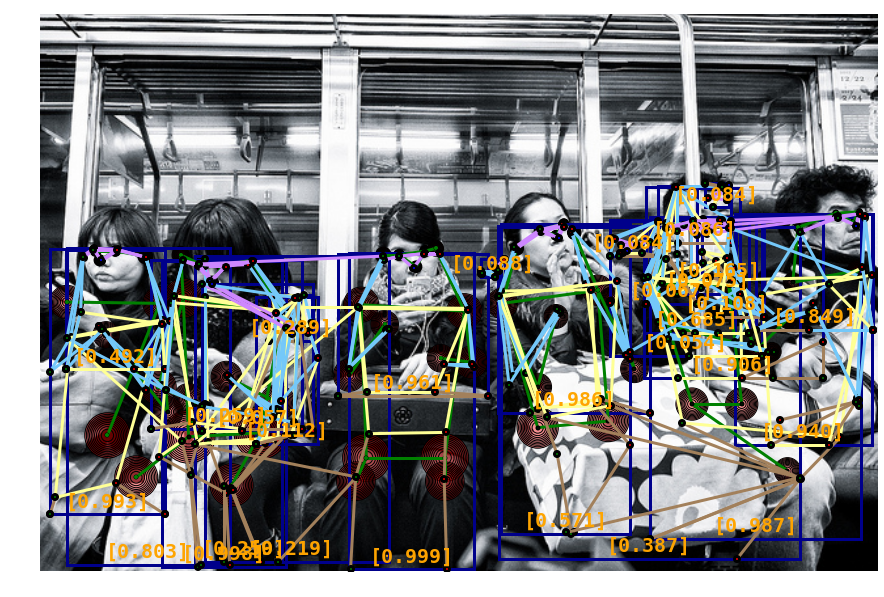

In [17]:
img_id = 163854
cur_img_dts = coco_dt.loadAnns(coco_dt.getAnnIds(img_id))
print len(cur_img_dts)
cur_img_gts = coco_gt.loadAnns(coco_gt.getAnnIds(img_id))
print len(cur_img_gts)

show_dets(
    cur_img_dts,
    cur_img_gts,
    imgs_info[img_id])

In [4]:
def show_dets(coco_dts, coco_gts, img_info, show_segm=False):
    if len(coco_dts) == 0 and len(coco_gts)==0:
        return 0
    
    ## color palette:
    # -brown:   #a2805b
    # -yellow:  #feff95
    # -blue:    #74c8f9
    # -fucsia:  #cd87ff
    
    # -green:   #249324
    # -red:     #d03535
    
    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9],
                [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]
    sigmas   = np.array([.026,.025,.025,.035,.035,.079,.079,.072,.072,.062,.062,.107,.107,.087,.087,.089,.089])
    oks      = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    a        = np.sqrt(-2*np.log(oks))
    NUM_KEYPOINTS = 17
    
    colors   = {(0,1): '#cd87ff',
                (0,2): '#cd87ff',
                (1,2): '#cd87ff',
                (1,3): '#cd87ff',
                (2,4): '#cd87ff',
                (3,5): '#74c8f9',
                (4,6): '#74c8f9',
                (5,6): '#feff95',
                (5,7): '#74c8f9',
                (5,11): '#feff95',
                (6,8): '#74c8f9',
                (6,12): '#feff95',
                (7,9): '#74c8f9',
                (8,10): '#74c8f9',
                (11,12): '#feff95',
                (13,11): '#a2805b',
                (14,12): '#a2805b',
                (15,13): '#a2805b',
                (16,14): '#a2805b'
    }

    I = io.imread('http://mscoco.org/images/%d'%(img_info['id']))
    plt.figure(figsize=(15,15)); plt.axis('off')
    plt.imshow(I)

    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
                
    for ann in coco_gts:
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
#         if ann['num_keypoints']==0:
#             continue

        if 'segmentation' in ann and show_segm:
            if type(ann['segmentation']) == list:
                # polygon
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((len(seg)/2, 2))
                    polygons.append(Polygon(poly))
                    color.append(c)
            else:
                # mask
                if type(ann['segmentation']['counts']) == list:
                    rle = mask.frPyObjects([ann['segmentation']], img_info['height'], img_info['width'])
                else:
                    rle = [ann['segmentation']]
                m = mask.decode(rle)
                img = np.ones( (m.shape[0], m.shape[1], 3) )
                if ann['iscrowd'] == 1:
                    color_mask = np.array([2.0,166.0,101.0])/255
                if ann['iscrowd'] == 0:
                    color_mask = np.random.random((1, 3)).tolist()[0]
                for i in range(3):
                    img[:,:,i] = color_mask[i]
                ax.imshow(np.dstack( (img, m*0.5) ))

        if 'keypoints' in ann and type(ann['keypoints']) == list:
            # turn skeleton into zero-based index
            sks = np.array(skeleton)-1
            kp = np.array(ann['keypoints'])
            x = kp[0::3]
            y = kp[1::3]
            v = kp[2::3]
            for sk in sks:
                if np.all(v[sk]>0):
                    plt.plot(x[sk],y[sk], linewidth=3, color='green')

            plt.plot(x[v>0], y[v>0],'o',markersize=2, markerfacecolor='green', 
                                        markeredgecolor='k',markeredgewidth=3)
            plt.plot(x[v>1], y[v>1],'o',markersize=2, markerfacecolor='green', 
                                        markeredgecolor='green', markeredgewidth=2)

            for x1, y1, sigma1 in zip(x[v>0], y[v>0], sigmas[v>0]):
                r = sigma1 * (np.sqrt(ann["area"])+np.spacing(1))
                #r = sigma1 * (ann["area"]+np.spacing(1))
                circle = plt.Circle((x1,y1), a[0]*r, fc=(1,0,0,0.4),ec='k')
                ax.add_patch(circle)
                for a1 in a[1:]:
                    circle = plt.Circle((x1,y1), a1*r, fc=(0,0,0,0),ec='k')
                    ax.add_patch(circle)

    for ann in coco_dts:
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        sks = np.array(skeleton)-1
        kp = np.array(ann['keypoints'])
        x = kp[0::3]
        y = kp[1::3]
        v = kp[2::3]
        for sk in sks:
            if np.all(v[sk]>0):
                #plt.plot(x[sk],y[sk], linewidth=3, color=c)
                plt.plot(x[sk],y[sk], linewidth=3, color=colors[sk[0],sk[1]])

        for kk in xrange(17):
            if kk in [1,3,5,7,9,11,13,15]:
                #plot left side red
                if v[kk]>0:
                    plt.plot(x[kk], y[kk],'o',markersize=5, markerfacecolor='r', 
                                              markeredgecolor='k',markeredgewidth=3)
                    
                if v[kk]>1:
                    plt.plot(x[kk], y[kk],'o',markersize=5, markerfacecolor='r', 
                                              markeredgecolor='r', markeredgewidth=3)
            elif kk in [2,4,6,8,10,12,14,16]:
                #plot right side green
                if v[kk]>0:
                    plt.plot(x[kk], y[kk],'o',markersize=5, markerfacecolor='g', 
                                              markeredgecolor='k',markeredgewidth=3)
                if v[kk]>1:
                    plt.plot(x[kk], y[kk],'o',markersize=5, markerfacecolor='g', 
                                              markeredgecolor='g', markeredgewidth=3)
            else:
                #plot nose neutral
                if v[kk]>0:
                    plt.plot(x[kk], y[kk],'o',markersize=5, markerfacecolor='b', 
                                              markeredgecolor='k',markeredgewidth=3)
                if v[kk]>1:
                    plt.plot(x[kk], y[kk],'o',markersize=5, markerfacecolor='b', 
                                              markeredgecolor='b', markeredgewidth=3)
        
        bbox  = ann['bbox']
        score = ann['score']
        oks   = 0.
        rect = plt.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,edgecolor='darkblue',linewidth=3)
        
        if len(coco_dts)==len(coco_gts)==1:
            #dt_kpt_arr = np.delete(kp, slice(2, None, 3))
            gt_kpt_arr = np.array(coco_gts[0]['keypoints'])

            xd = x; yd = y
            xg = gt_kpt_arr[0::3]; yg = gt_kpt_arr[1::3]; vg = gt_kpt_arr[2::3]

            # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
            z = np.zeros((len(sigmas)))

            dx = xd - xg
            dy = yd - yg

            e = (dx**2 + dy**2) / (sigmas * 2)**2 / (coco_gts[0]['area']+np.spacing(1)) / 2
            e = e[vg > 0]
            oks = np.sum(np.exp(-e)) / e.shape[0]
            print oks
        
        ax.annotate("[%.3f]"%(score), (bbox[0]+bbox[2]/2., bbox[1]+bbox[3] - 10), 
                    color='orange', weight='bold', fontsize=20, ha='center', va='center')
        ax.add_patch(rect)

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor="none", edgecolors=color, linewidths=2)
    ax.add_collection(p)
    
    plt.show()